In [1]:
import sys
import LangtjernWeather as lw
import numpy as np
import datetime
import pandas as pd
import getpass
import matplotlib
import matplotlib.pyplot as plt
import getpass
import itertools as IT
from itertools import compress
from matplotlib import rc
import shutil
import os
import re
import pickle
import pylab
import statsmodels.api as sm
from patsy import dmatrices

#Setting matplotlib style
matplotlib.style.use('ggplot')
%matplotlib inline
pd.options.mode.chained_assignment = None
rc('text', usetex=True)
rc('xtick', labelsize = 16)
rc('ytick', labelsize = 16)
rc('font', size = 16)
#login function
def login():
    username = input("Username: [JLG] ") #default username JLG
    if not username :
        username = "JLG"
    password = getpass.getpass('Password: ')
    return username, password

#Creating directories to store files. This will overwrite if the directory already exists
def create_dir(dir_name) :
    if not os.path.exists(dir_name) :
        os.makedirs(dir_name)
    else :
        shutil.rmtree(dir_name)
        os.makedirs(dir_name)
#Helper function for plotting
def plot_df(df) :
    num_cols = len(df.columns)
    fig, axes = plt.subplots(nrows = num_cols, ncols = 1, figsize = (20, num_cols * 5))
    for name,ax_h in zip(df.columns, axes) :
        plt.sca(ax_h)
        plt.plot(df.index,df[name])
        #df[name].plot(ax = ax_h)
        ax_h.set_ylabel(name)
    return fig

def isnumber(x):
    try:
        float(x)
        return True
    except:
        return False

#Sanity check
print("Using python version:")
print(sys.version)
print("Paths to python libraries:")
print(sys.path)

#Creating directory to save results
result_dir = './results/'
create_dir(result_dir)    

Using python version:
3.6.3 (default, Oct  3 2017, 21:45:48) 
[GCC 7.2.0]
Paths to python libraries:
['', '/home/jose-luis/Envs/prognos_get_data_py3/lib/python36.zip', '/home/jose-luis/Envs/prognos_get_data_py3/lib/python3.6', '/home/jose-luis/Envs/prognos_get_data_py3/lib/python3.6/lib-dynload', '/usr/lib/python3.6', '/home/jose-luis/Envs/prognos_get_data_py3/lib/python3.6/site-packages', '/home/jose-luis/Envs/prognos_get_data_py3/lib/python3.6/site-packages/IPython/extensions', '/home/jose-luis/.ipython']


# Creating data files for GOTM ∕ FABM
## Credentials for Aquamonitor

In [2]:
username,password = login()

#Folder where the downloaded data will be saved
root = "./DownloadedData/"
create_dir(root)

Username: [JLG]  
Password:  ··············


## Defining period to download
This should be the same as in the "Catchment_and_weather" notebook

In [3]:
now = pd.to_datetime('today').strftime('%Y-%m-%d')
datesToGet = '2016-01-01/{}'.format(now)
# datesToGet = '2010-01-01/{}'.format(now)
start = datesToGet.split('/')

finish = pd.datetime.strptime(start[1],'%Y-%m-%d')
start = pd.datetime.strptime(start[0],'%Y-%m-%d')

# finish_dt = pd.datetime.strftime(finish,'%Y-%m-%d')
# start_dt = pd.datetime.strftime(start,'%Y-%m-%d')
# display(finish)

## Downloading meteo data measured locally at Langtjern

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f96e1db35c0>,
      dtype=object)

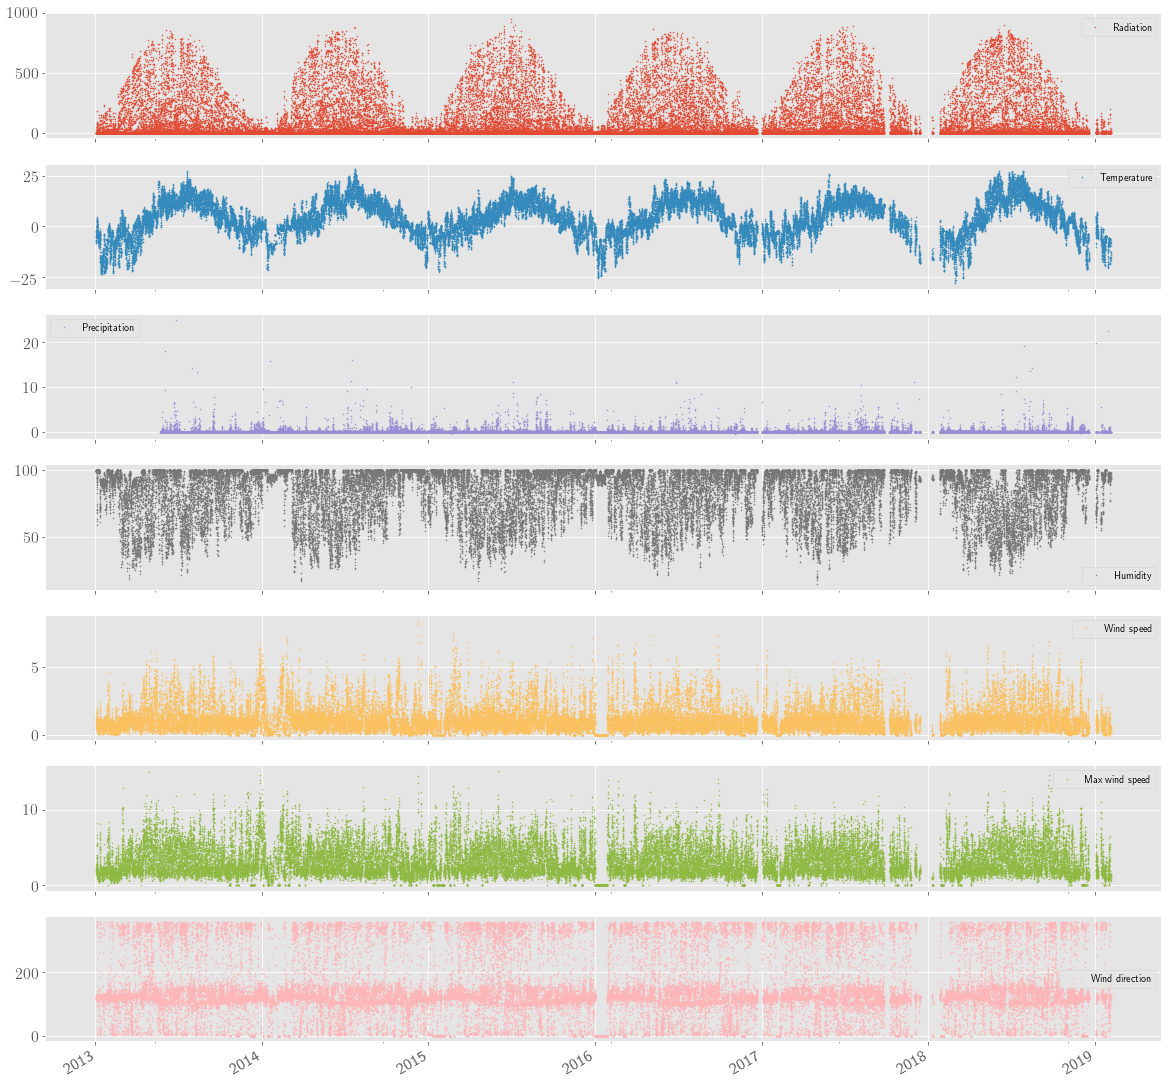

In [4]:
lake = lw.getLangtjernData(username,password,root,
                           pd.datetime.strftime(start,'%Y/%m/%d'),
                           pd.datetime.strftime(finish,'%Y/%m/%d'),
                           62040,
                           'Air')
lake.drop(['ProjectId','ProjectName','StationId','StationCode','StationName','SampleDate_dato','SampleDate_tid'],
         inplace=True, axis=1)
lake.columns = lake.columns.str.strip()
lake.rename(columns={'Lufttemperatur_°C': 'Temperature',
                     'Globalstråling_W/m2' : 'Radiation',
                     'Nedbør_mm' : 'Precipitation',
                     'Relativ luftfuktighet_%': 'Humidity',
                      'Vindhastighet_m/s' : 'Wind speed',
                     'Vindhastighet (maks)_m/s' : 'Max wind speed',
                     'Vindretning_°' : 'Wind direction'                    
                    },
            inplace=True)

#display(lake)
lake.plot(subplots=True,figsize=(20,3*lake.shape[1]),
          marker='.',
          markersize=1,
          linestyle='None')

## Using data from nearby stations to patch time series

In [5]:
filename = 'metno.pickle'
with open(filename, "rb") as f:
    meta,data = pickle.load(f) 

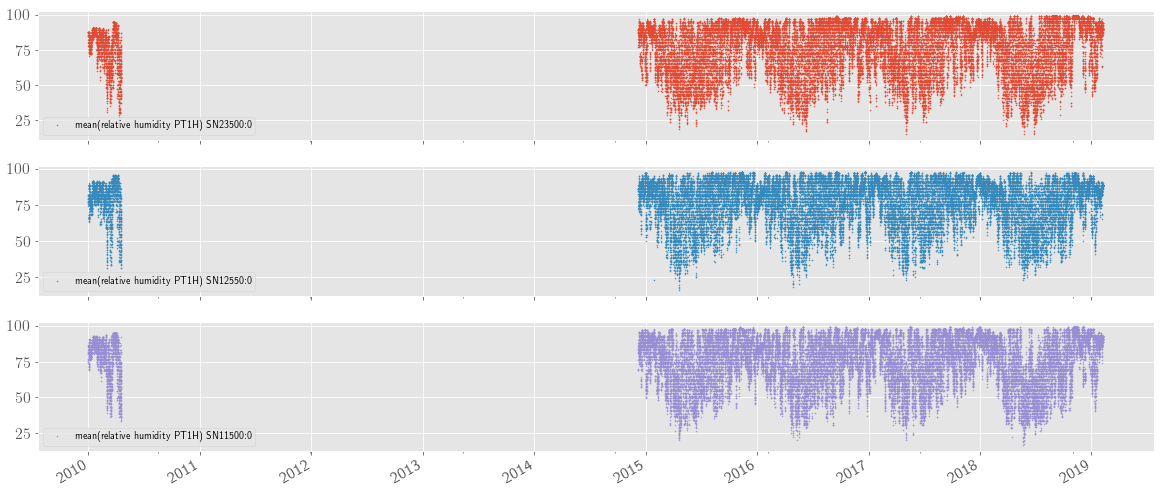

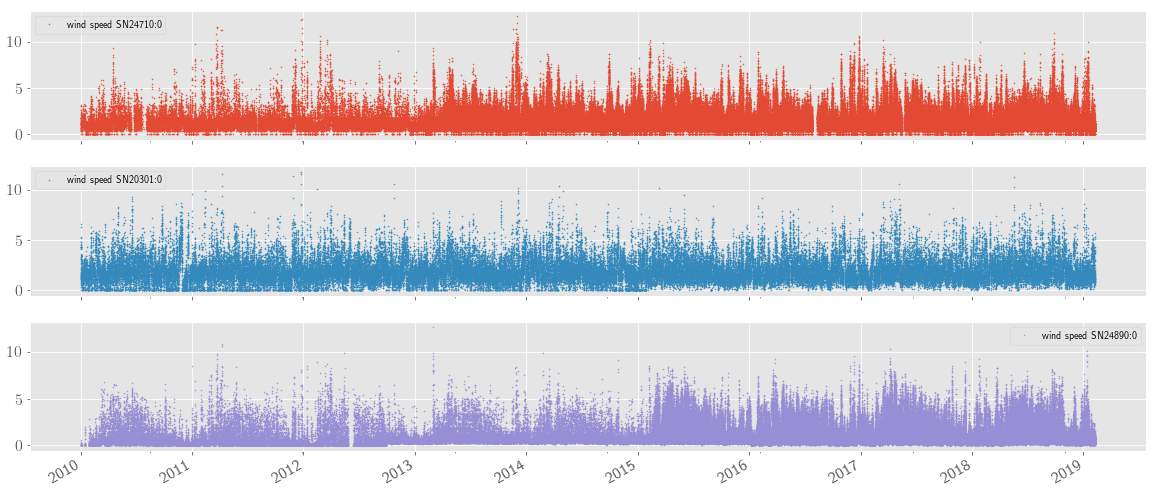

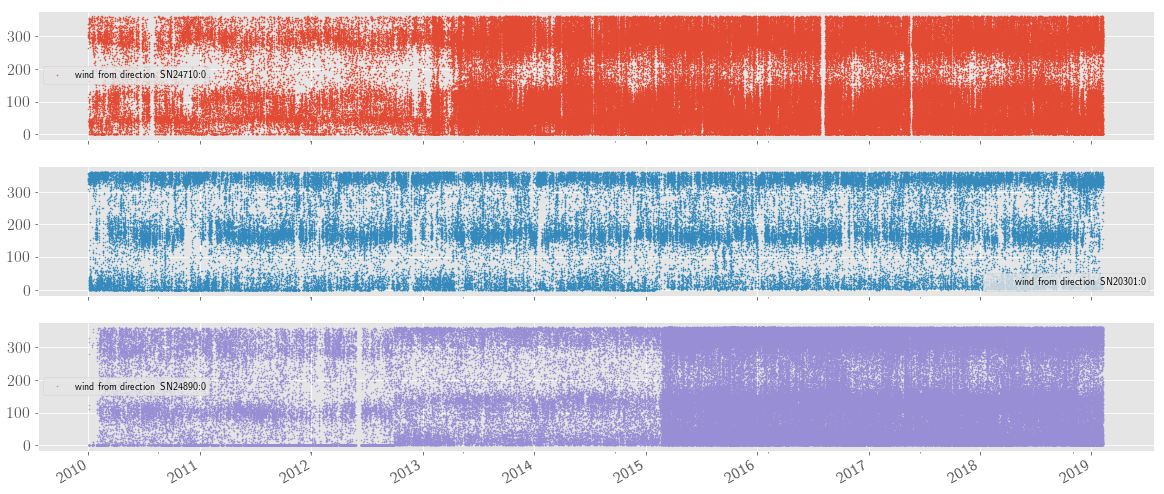

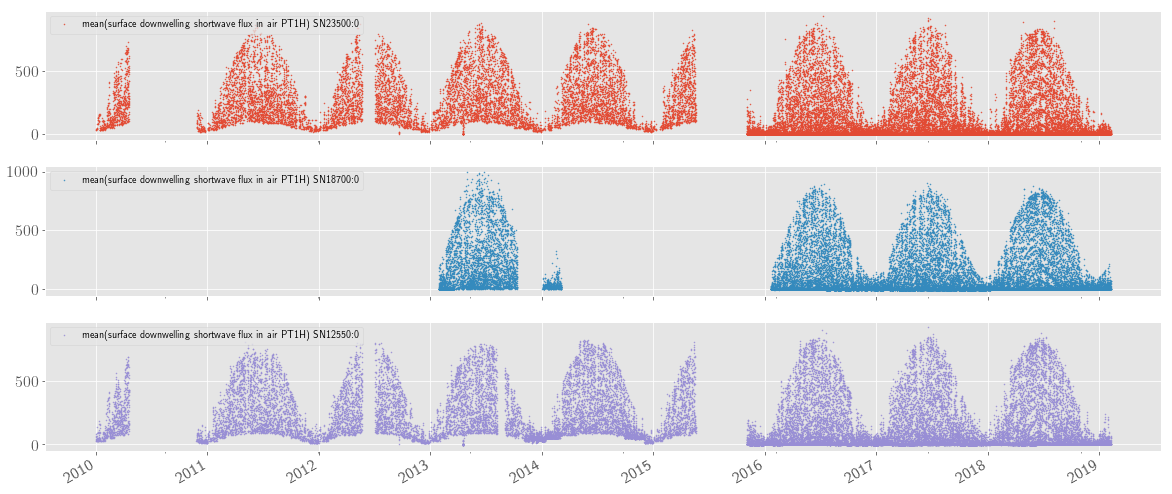

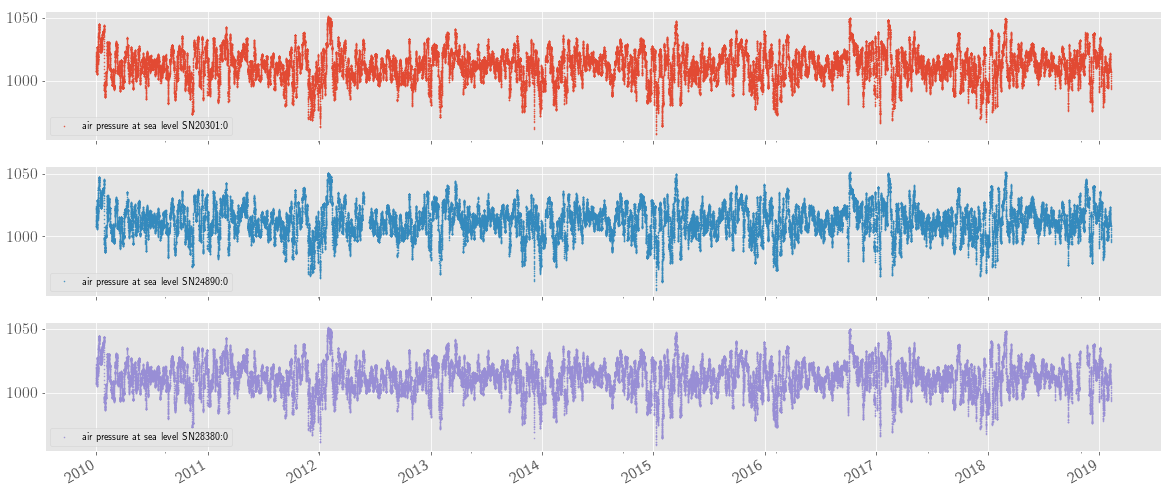

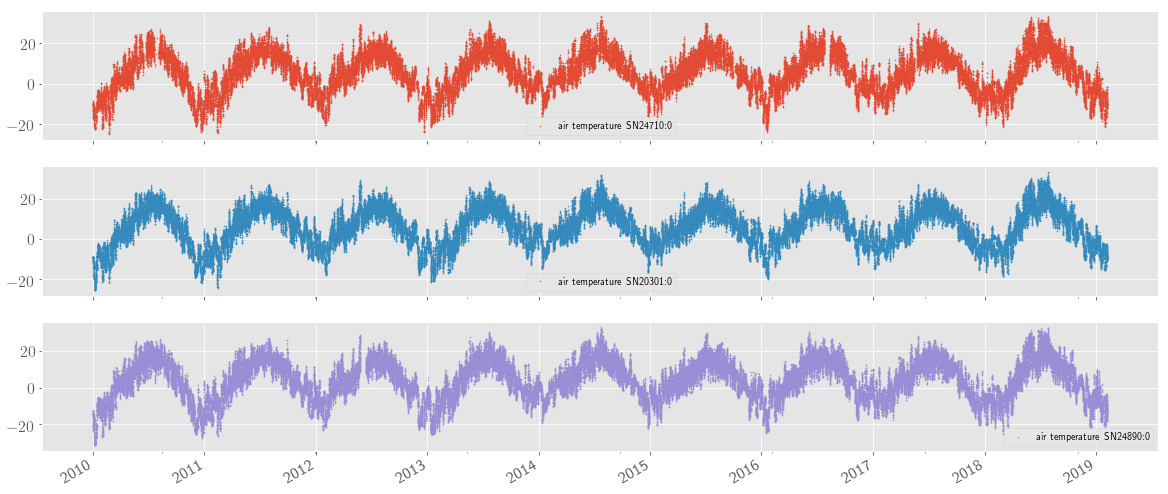

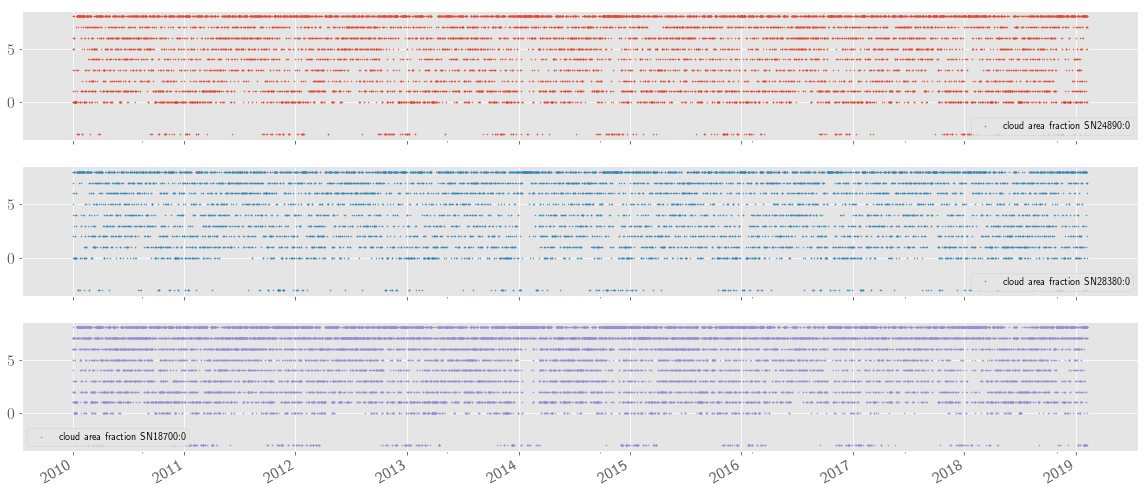

In [6]:
def plotVar(variable):
    data[variable].plot(subplots=True,
                           figsize=(20,3*len(data[variable].columns)),
                           marker='.',
                           markersize=1,                           
                           linestyle='None'
                       )    
for key,df in data.items():
    df.columns = df.columns.str.strip().str.replace('_',' ')
    plotVar(key)

### Patching humidity

In [7]:
startDf = lake['Humidity'].index[0]
endDf = lake['Humidity'].index[-1]

predictors = data['humidity']
predictors.columns = ['a','b','c']
humidity = pd.concat([lake['Humidity'].to_frame(),predictors],axis=1, join='inner')
humidity.dropna(inplace=True)
y, X = dmatrices('Humidity ~ 0 + a + b + c', data=humidity)

model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Humidity   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                 1.177e+06
Date:                Fri, 08 Feb 2019   Prob (F-statistic):               0.00
Time:                        10:29:17   Log-Likelihood:            -1.1839e+05
No. Observations:               33590   AIC:                         2.368e+05
Df Residuals:                   33587   BIC:                         2.368e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
a              0.5138      0.004    118.830      0.000       0.505       0.522
b              0.2454      0.006     39.357      0.000       0.233       0.258
c              0.3348      0.007     48.863      0.000       0.321       0.348
==============================================================================
Omnibus:                     1021.088   Durbin-Watson:                   0.293
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2255.179
Skew:                           0.176   Prob(JB):                         0.00
Kurtosis:                       4.220   Cond. No.                         26.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

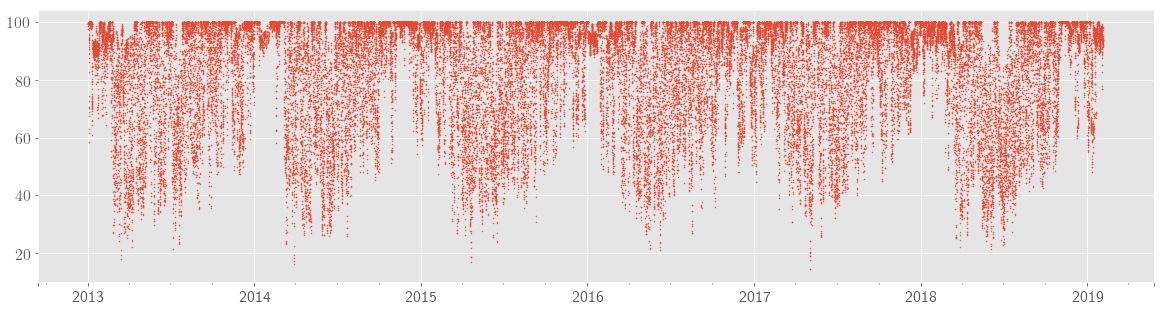

In [8]:
filledHumidity = pd.date_range(startDf, endDf, freq='H')
filledHumidity = pd.DataFrame(index = filledHumidity)
filledHumidity=pd.merge(filledHumidity,lake['Humidity'].to_frame(),left_index = True, right_index = True, how = 'left')     
filledHumidity = pd.concat([filledHumidity,data['humidity']], axis = 1, join_axes = [filledHumidity.index])


filledHumidity['Humidity'] = filledHumidity.apply(lambda row : np.float64(min(model.predict(row[['a','b','c']].values),100.)) 
                                                   if np.isnan(row['Humidity']) and np.logical_not(np.isnan(row.values[1:]).any()) 
                                                   else row['Humidity'],
                                                   axis=1)
#display(filledHumidity)
#filledHumidity=filledHumidity.astype('float')
filledHumidity['Humidity'].plot(figsize=(20,5),marker='.',markersize=1,linestyle='None')

In [9]:
display(filledHumidity.isnull().sum())
filledHumidity['Humidity'].interpolate(method='time',inplace=True)

Humidity      346
a           16946
b           17135
c           16965
dtype: int64

### Patching wind speed

In [10]:
startDf = lake['Wind speed'].index[0]
endDf = lake['Wind speed'].index[-1]

predictors = data['wind_speed']
predictors.columns = ['a','b','c']
ws = pd.concat([lake['Wind speed'].to_frame(),predictors],axis=1, join='inner')
ws.dropna(inplace=True)
ws.columns = ws.columns.str.replace(' ','_')
y, X = dmatrices('Wind_speed ~ a + b + c  - 1', data=ws)

model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Wind_speed   R-squared:                       0.667
Model:                            OLS   Adj. R-squared:                  0.667
Method:                 Least Squares   F-statistic:                 3.239e+04
Date:                Fri, 08 Feb 2019   Prob (F-statistic):               0.00
Time:                        10:29:21   Log-Likelihood:                -64111.
No. Observations:               48523   AIC:                         1.282e+05
Df Residuals:                   48520   BIC:                         1.283e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
a              0.1045      0.004     27.525      0.000       0.097       0.112
b              0.2870      0.003     97.762      0.000       0.281       0.293
c              0.2810      0.004     70.431      0.000       0.273       0.289
==============================================================================
Omnibus:                     7354.336   Durbin-Watson:                   0.375
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            13914.342
Skew:                           0.957   Prob(JB):                         0.00
Kurtosis:                       4.794   Cond. No.                         3.63
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

array([0.10452253, 0.28702746, 0.28097024])

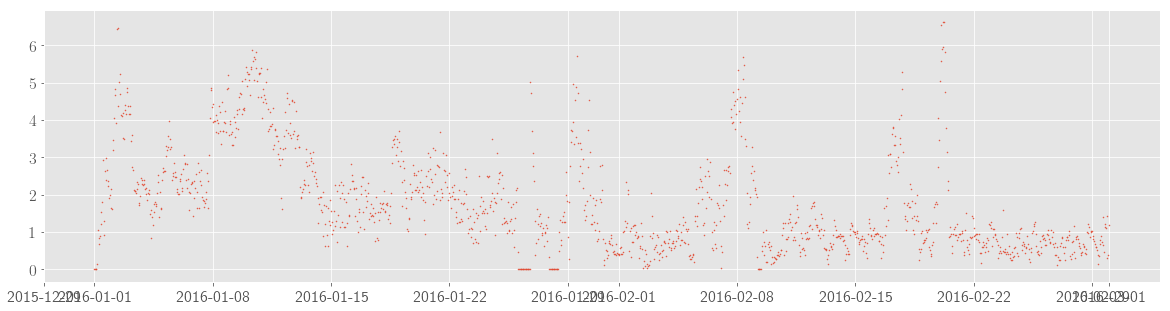

In [11]:
filledWind = pd.date_range(startDf, endDf, freq='H')
filledWind = pd.DataFrame(index = filledWind)

filledWind=pd.merge(filledWind,lake['Wind speed'].to_frame(),left_index = True, right_index = True, how = 'outer')
filledWind = pd.concat([filledWind,data['wind_speed']], axis = 1, join_axes = [filledWind.index])
#filledWind = pd.merge(filledWind,temp,left_index = True, right_index = True, how = 'inner')

#patching if an entire day with no wind
group = filledWind.groupby('Wind speed')
idx = np.cumsum(np.diff(group.indices[0.0]) != 1)
idx = np.insert(idx,0,1) if idx[1] != idx[0] else np.insert(idx,0,0)
val, count = np.unique(idx, return_counts = True)
#Filling only if there are more than 24 hours missing
valToFill = val[count >= 24]
allIdx = [group.indices[0.0][np.equal(idx,i)] for i in valToFill]
allIdx = np.concatenate(allIdx).ravel().tolist()
#np.set_printoptions(threshold=np.nan)
#display(allIdx[0],group.indices[0.0])
#display(allIdx)


filledWind['Wind speed'] = filledWind.apply(lambda row : np.float64(model.predict(row[['a','b','c']].values)) #np.float64(model.predict(row[['a','b','a:b','c','a:c','b:c','a:b:c']].values))
                                                   if np.isnan(row['Wind speed']) and np.logical_not(np.isnan(row.values[1:]).any()) 
                                                   else row['Wind speed'],
                                                   axis=1
                                           )
#Filling if there is more than a day without wind
display(model.params)
filledWind.iloc[allIdx,0] = filledWind['a'] * model.params[0] + filledWind['b'] + model.params[1] + filledWind['c'] * model.params[2]
view=filledWind[pd.Timestamp('2016-01-01'):pd.Timestamp('2016-03-01')].copy()

fig = plt.figure(figsize=(20,5))
plt.plot(view.index,view['Wind speed'],marker='.',markersize=1,linestyle='None')


# view['a'].plot(figsize=(20,5),
#                               marker='.',
#                               markersize=1,
#                               linestyle='None',
#                          #    xlim=(pd.Timestamp('2016-01-01'),pd.Timestamp('2016-03-01'))
#                              )

#filledWind['Wind speed'].plot(figsize=(20,5),marker='.',markersize=1,linestyle='None')

In [12]:
display(filledWind.isnull().sum())
filledWind['Wind speed'].interpolate(method='time',inplace=True, limit = 24)
display(filledWind.isnull().sum())

Wind speed     115
a             1688
b               30
c              206
dtype: int64

Wind speed      13
a             1688
b               30
c              206
dtype: int64

## Patching wind direction

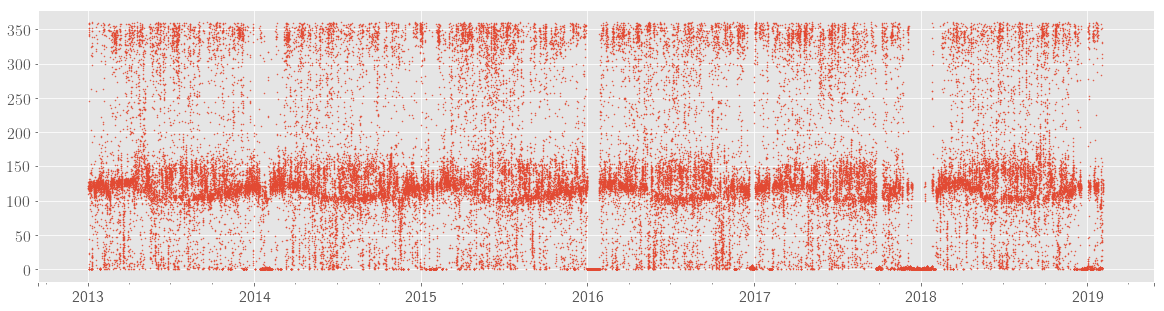

In [13]:
startDf = lake['Wind direction'].index[0]
endDf = lake['Wind direction'].index[-1]
filledDir = pd.date_range(startDf, endDf, freq='H')
filledDir = pd.DataFrame(index = filledDir)

filledDir=pd.merge(filledDir,lake['Wind direction'].to_frame(),left_index = True, right_index = True, how = 'outer')
filledDir = pd.concat([filledDir,data['wind_speed']], axis = 1, join_axes = [filledDir.index])
#filledWind = pd.merge(filledWind,temp,left_index = True, right_index = True, how = 'inner')

from scipy.stats import circmean
def circ(data):
    radAng = [(i%360 * np.pi ) / 180. for i in data]
    result = circmean(radAng)
    return (result * 180. / np.pi)


filledDir['Wind direction'] = filledDir.apply(lambda row : circ(row[['a','b','c']].values) #np.float64(model.predict(row[['a','b','a:b','c','a:c','b:c','a:b:c']].values))
                                                   if np.isnan(row['Wind direction']) 
                                                   else row['Wind direction'],
                                                   axis=1
                                             )
filledDir['Wind direction'].plot(figsize=(20,5),marker='.',markersize=1,linestyle='None')

## Patching shortwave radiation

In [14]:
startDf = lake['Radiation'].index[0]
endDf = lake['Radiation'].index[-1]

#Radiation shouldn't be negative
lake.loc[lake.Radiation < 0.0, 'Radiation'] = 0.0
data['radiation'][data['radiation'] < 0.0] = 0.0
# display(lake['Radiation'].min())

predictors = data['radiation']
predictors.columns = ['a','b','c']
humidity = pd.concat([lake['Radiation'].to_frame(),predictors],axis=1, join='inner')
humidity.dropna(inplace=True)
y, X = dmatrices('Radiation ~ 0 + a + b + c', data=humidity)

model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Radiation   R-squared:                       0.925
Model:                            OLS   Adj. R-squared:                  0.925
Method:                 Least Squares   F-statistic:                 1.061e+05
Date:                Fri, 08 Feb 2019   Prob (F-statistic):               0.00
Time:                        10:29:30   Log-Likelihood:            -1.4447e+05
No. Observations:               25931   AIC:                         2.889e+05
Df Residuals:                   25928   BIC:                         2.890e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
a              0.3561      0.005     75.280      0.000       0.347       0.365
b              0.2785      0.005     60.109      0.000       0.269       0.288
c              0.2998      0.005     55.716      0.000       0.289       0.310
==============================================================================
Omnibus:                     5153.018   Durbin-Watson:                   1.090
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           114165.947
Skew:                          -0.379   Prob(JB):                         0.00
Kurtosis:                      13.251   Cond. No.                         6.88
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

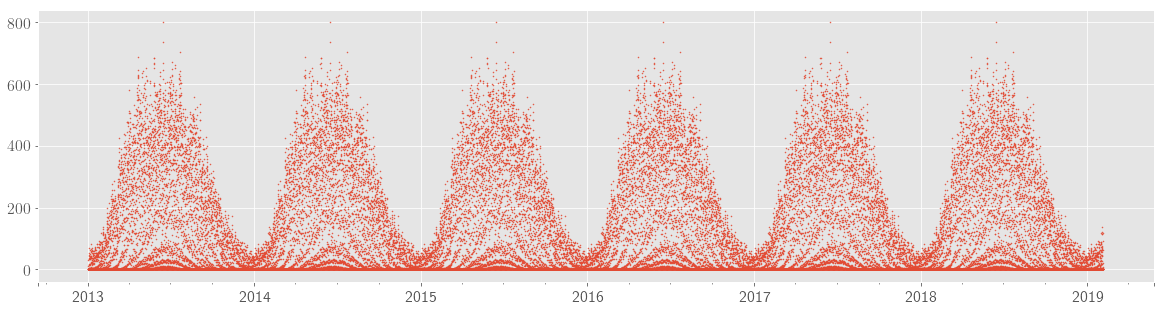

In [15]:
#Filling from nearby stations if available, using the model above
filledRad = pd.date_range(startDf, endDf, freq='H')
filledRad = pd.DataFrame(index = filledRad)
filledRad = pd.merge(filledRad,lake['Radiation'].to_frame(),left_index = True, right_index = True, how = 'outer')
filledRad = pd.concat([filledRad,data['radiation']], axis = 1, join_axes = [filledRad.index])
#filledRad = pd.merge(filledRad,data['radiation'],left_index = True, right_index = True, how = 'inner') 

filledRad['Radiation'] = filledRad.apply(lambda row : np.float64(model.predict(row[['a','b','c']].values)) 
                                                   if np.isnan(row['Radiation']) and np.logical_not(np.isnan(row.values[1:]).any()) 
                                                   else row['Radiation'],
                                                   axis=1)
#display(filledHumidity)
#filledHumidity=filledHumidity.astype('float')
#filledRad['Radiation'].plot(figsize=(20,5),marker='.',markersize=1,linestyle='None')

#If there are still missing values fill with the average for that particular day/hour of the year
filledRad['day'] = filledRad.index.dayofyear
filledRad['hour'] = filledRad.index.hour
group = filledRad.groupby(['day','hour']).mean()

filledRad['Radiation'] = filledRad.apply( lambda row :  group.loc[row.day,row.hour]['Radiation'], axis = 1) 
filledRad['Radiation'].plot(figsize=(20,5),marker='.',markersize=1,linestyle='None')

In [16]:
display(filledRad.isnull().sum())
filledRad['Radiation'].interpolate(method='time',inplace=True)

Radiation        0
a            18221
b            21959
c            15832
day              0
hour             0
dtype: int64

In [17]:
display(group.loc[1,0]['Radiation'])

0.23230471747963113

## Patching temperature

In [18]:
startDf = lake['Temperature'].index[0]
endDf = lake['Temperature'].index[-1]

#Radiation shouldn't be negative

predictors = data['air_temperature']
predictors.columns = ['a','b','c']
temperature = pd.concat([lake['Temperature'].to_frame(),predictors],axis=1, join='inner')
temperature.dropna(inplace=True)
y, X = dmatrices('Temperature ~ 0 + a + b + c', data=temperature)

model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Temperature   R-squared:                       0.947
Model:                            OLS   Adj. R-squared:                  0.947
Method:                 Least Squares   F-statistic:                 2.881e+05
Date:                Fri, 08 Feb 2019   Prob (F-statistic):               0.00
Time:                        10:29:48   Log-Likelihood:            -1.0613e+05
No. Observations:               47920   AIC:                         2.123e+05
Df Residuals:                   47917   BIC:                         2.123e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
a              0.3080      0.007     44.876      0.000       0.295       0.321
b              0.0662      0.005     12.509      0.000       0.056       0.077
c              0.4731      0.004    112.148      0.000       0.465       0.481
==============================================================================
Omnibus:                     2350.858   Durbin-Watson:                   0.164
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8820.254
Skew:                           0.036   Prob(JB):                         0.00
Kurtosis:                       5.101   Cond. No.                         16.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

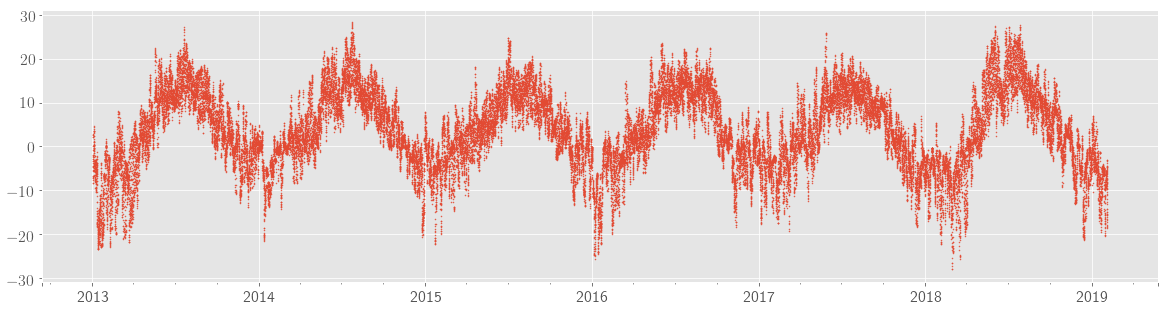

In [19]:
#Filling from nearby stations if available, using the model above
filledTemp = pd.date_range(startDf, endDf, freq='H')
filledTemp = pd.DataFrame(index = filledTemp)
filledTemp = pd.merge(filledTemp, lake['Temperature'].to_frame(),left_index = True, right_index = True, how = 'outer')   
filledTemp = pd.concat([filledTemp,data['air_temperature']], axis = 1, join_axes = [filledTemp.index])
#filledTemp = pd.merge(filledTemp, data['air_temperature'],left_index = True, right_index = True, how = 'inner') 

filledTemp['Temperature'] = filledTemp.apply(lambda row : np.float64(model.predict(row[['a','b','c']].values)) 
                                                   if np.isnan(row['Temperature']) and np.logical_not(np.isnan(row.values[1:]).any()) 
                                                   else row['Temperature'],
                                                   axis=1)
filledTemp['Temperature'].plot(figsize=(20,5),marker='.',markersize=1,linestyle='None')

#If there are still missing values, interpolate from existing values
#Should eventually add a sanity check but there are only 9 values that were not filled for this case
filledTemp['Temperature'].interpolate(method='time',inplace=True)

In [20]:
display(filledTemp.isnull().sum())

Temperature       0
a              2468
b                17
c                17
dtype: int64

## Getting mean sea level pressure from nearby stations
There are no measurements at Langtjern. The inverse distance weighting method will be used

[61.91, 69.12, 82.65]

/home/jose-luis/Envs/prognos_get_data_py3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


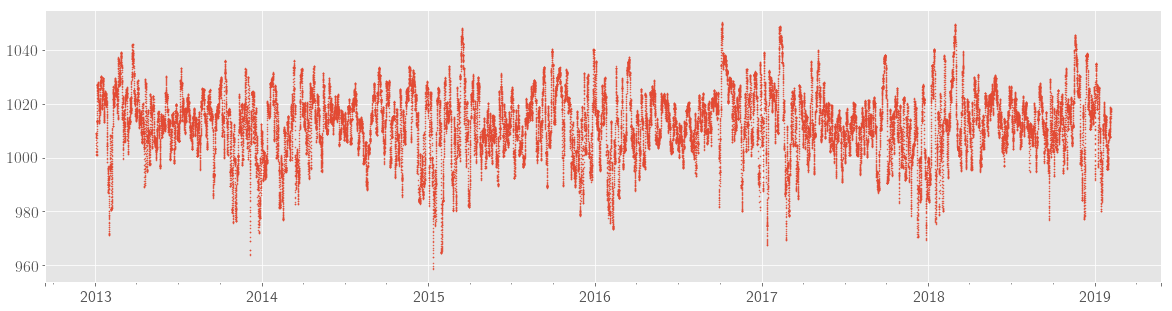

In [21]:
startDf = lake['Radiation'].index[0]
endDf = lake['Radiation'].index[-1]

#Filling from nearby stations if available, using the model above
filledPressure = pd.date_range(startDf, endDf, freq='H')
filledPressure = pd.DataFrame(index = filledPressure)
filledPressure = pd.merge(filledPressure, data['air_pressure'],left_index = True, right_index = True, how = 'inner') 


filledPressure.columns = [re.search('SN[0-9:]+',i)[0] for i in filledPressure.columns]

distance = new_dict = {item['id']:item['distance'] for item in meta['air_pressure']}
display( [ float(distance[i]) for i in filledPressure.columns])

weights = np.array([1./float(distance[i]) for i in filledPressure.columns])
def weightedValues(row):
    vals = np.array(row.values[:3]).astype(float)
    idx = np.logical_not(np.isnan(vals)).astype(float)
    denominator = np.nansum(np.multiply(weights,vals))
    return(np.divide(denominator,np.nansum(np.multiply(idx,weights))))
    
filledPressure['Pressure'] = filledPressure.apply(lambda row : weightedValues(row) , axis = 1)  

#Should eventually add a sanity check but there are only 9 values that were not filled for this case
filledPressure['Pressure'].interpolate(method='time',inplace=True)
filledPressure['Pressure'].plot(figsize=(20,5),marker='.',markersize=1,linestyle='None')

In [22]:
display(filledPressure.isnull().sum())

SN20301:0     96
SN24890:0     30
SN28380:0    952
Pressure       0
dtype: int64

## Getting cloud cover pressure from nearby stations
There are no cloud cover measurements at Langtjern. The inverse distance weighting method will be used

[69.12, 82.65, 119.55]

/home/jose-luis/Envs/prognos_get_data_py3/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide


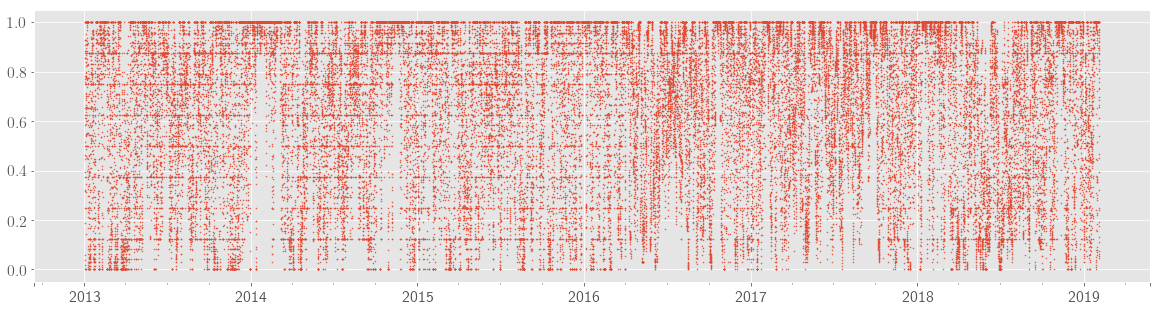

In [23]:
startDf = lake['Radiation'].index[0]
endDf = lake['Radiation'].index[-1]

#A value of -3 in the cloud cover generally indicates fog
#Filling from nearby stations using inverse distance weighting
filledCC = pd.date_range(startDf, endDf, freq='H')
filledCC = pd.DataFrame(index = filledCC)
filledCC = pd.concat([filledCC,data['cloud_cover']], axis = 1, join_axes = [filledCC.index])

#Getting rid of -3's
filledCC[filledCC<0] = 8.;
#Mapping to the 0--1 range
filledCC = (filledCC/8.)

filledCC.columns = [re.search('SN[0-9:]+',i)[0] for i in filledCC.columns]

distance = new_dict = {item['id']:item['distance'] for item in meta['cloud_cover']}
display( [ float(distance[i]) for i in filledCC.columns])

weights = np.array([1./float(distance[i]) for i in filledCC.columns])
def weightedValues(row):
    vals = np.array(row.values[:3]).astype(float)
    idx = np.logical_not(np.isnan(vals)).astype(float)
    denominator = np.nansum(np.multiply(weights,vals))
    return(np.divide(denominator,np.nansum(np.multiply(idx,weights))))
    
filledCC['Cloud'] = filledCC.apply(lambda row : weightedValues(row) , axis = 1)  

#Should eventually add a sanity check but there are only 9 values that were not filled for this case
filledCC['Cloud'].interpolate(method='time',inplace=True)
#Ad hoc, filling the first two values instead of extapolating
filledCC['Cloud'][:2] = 1.0
filledCC['Cloud'].plot(figsize=(20,5),marker='.',markersize=1,linestyle='None')

Temperature     Pressure  Wind speed  Wind direction  \
2013-01-02 13:00:00    -4.503000  1007.464787    0.533000      109.200000   
2013-01-02 14:00:00    -4.729000  1007.772675    0.435000      121.100000   
2013-01-02 15:00:00    -5.672000  1008.453699    0.571000      119.100000   
2013-01-02 16:00:00    -6.681000  1008.841011    0.504000      116.700000   
2013-01-02 17:00:00    -6.970000  1009.169333    0.731000      127.700000   
2013-01-02 18:00:00    -7.294000  1009.111088    0.929000      118.300000   
2013-01-02 19:00:00    -8.310000  1009.174877    0.987000      121.200000   
2013-01-02 20:00:00    -8.290000  1009.009488    1.070000      121.600000   
2013-01-02 21:00:00    -7.116000  1008.632267    1.294000      118.000000   
2013-01-02 22:00:00    -7.721000  1008.113432    1.175000      119.100000   
2013-01-02 23:00:00    -6.852000  1007.498400    1.280000      119.300000   
2013-01-03 00:00:00    -5.395000  1006.683368    1.125000      115.600000   
2013-01-03 01:00:00    -4.435000  1005.413290    0.649000      116.700000   
2013-01-03 02:00:00    -3.794000  1004.889656    0.403000      117.000000   
2013-01-03 03:00:00    -2.924000  1003.721179    0.798158        1.099992   
2013-01-03 04:00:00    -2.888000  1002.545557    0.422974        0.600000   
2013-01-03 05:00:00    -2.448000  1001.922779    0.495601        0.666667   
2013-01-03 06:00:00    -1.998000  1001.440013    0.337472        0.500000   
2013-01-03 07:00:00    -2.231000  1000.894314    0.706973        0.933333   
2013-01-03 08:00:00    -3.419000  1001.024981    0.578681        0.766664   
2013-01-03 09:00:00    -4.616000  1001.087170    1.657000      131.200000   
2013-01-03 10:00:00    -3.297000  1001.487170    1.602000      117.800000   
2013-01-03 11:00:00    -0.842000  1002.228181    0.421000       44.410000   
2013-01-03 12:00:00     2.607000  1002.560447    0.761000        7.334000   
2013-01-03 13:00:00     2.606000  1003.362047    0.761000        3.004000   
2013-01-03 14:00:00     2.746000  1004.369191    0.963000      357.700000   
2013-01-03 15:00:00     2.089000  1005.858245    0.667000      343.300000   
2013-01-03 16:00:00     2.106000  1007.207605    0.328000       23.170000   
2013-01-03 17:00:00    -2.033000  1008.267733    0.822000      110.900000   
2013-01-03 18:00:00     0.142000  1009.203802    0.652000       24.270000   
...                          ...          ...         ...             ...   
2019-02-03 07:00:00   -10.308326  1014.313655    1.025963        1.366648   
2019-02-03 08:00:00   -11.177610  1014.762554    1.126553        1.800021   
2019-02-03 09:00:00   -10.893799  1015.123144    0.788543        1.133332   
2019-02-03 10:00:00    -9.101479  1015.019944    0.645798        1.199991   
2019-02-03 11:00:00    -9.810000  1015.104912    0.220000      132.500000   
2019-02-03 12:00:00    -8.450000  1014.773389    0.169000      112.500000   
2019-02-03 13:00:00    -8.460000  1014.618344    0.044000      150.900000   
2019-02-03 14:00:00    -7.679000  1014.514400    0.107000      156.400000   
2019-02-03 15:00:00   -12.040000  1014.650610    0.647000      126.400000   
2019-02-03 16:00:00   -14.880000  1015.316744    0.791000      120.000000   
2019-02-03 17:00:00   -15.510000  1016.067845    0.388000      130.900000   
2019-02-03 18:00:00   -15.630000  1016.686821    0.740000      124.500000   
2019-02-03 19:00:00   -15.380000  1017.045066    0.783000      123.600000   
2019-02-03 20:00:00   -16.060000  1017.411200    0.562000      125.000000   
2019-02-03 21:00:00   -16.850000  1017.877333    0.424000      123.200000   
2019-02-03 22:00:00   -17.240000  1018.205656    0.532000      118.000000   
2019-02-03 23:00:00   -18.140000  1018.501712    0.428000      119.000000   
2019-02-04 00:00:00   -17.890000  1018.841122    0.540000      119.400000   
2019-02-04 01:00:00   -18.700000  1018.909600    0.447000      126.500000   
2019-02-04 02:00:00   -18.390000  1018.641866    0.533000      119.500000   
2019-02-04 03:00:

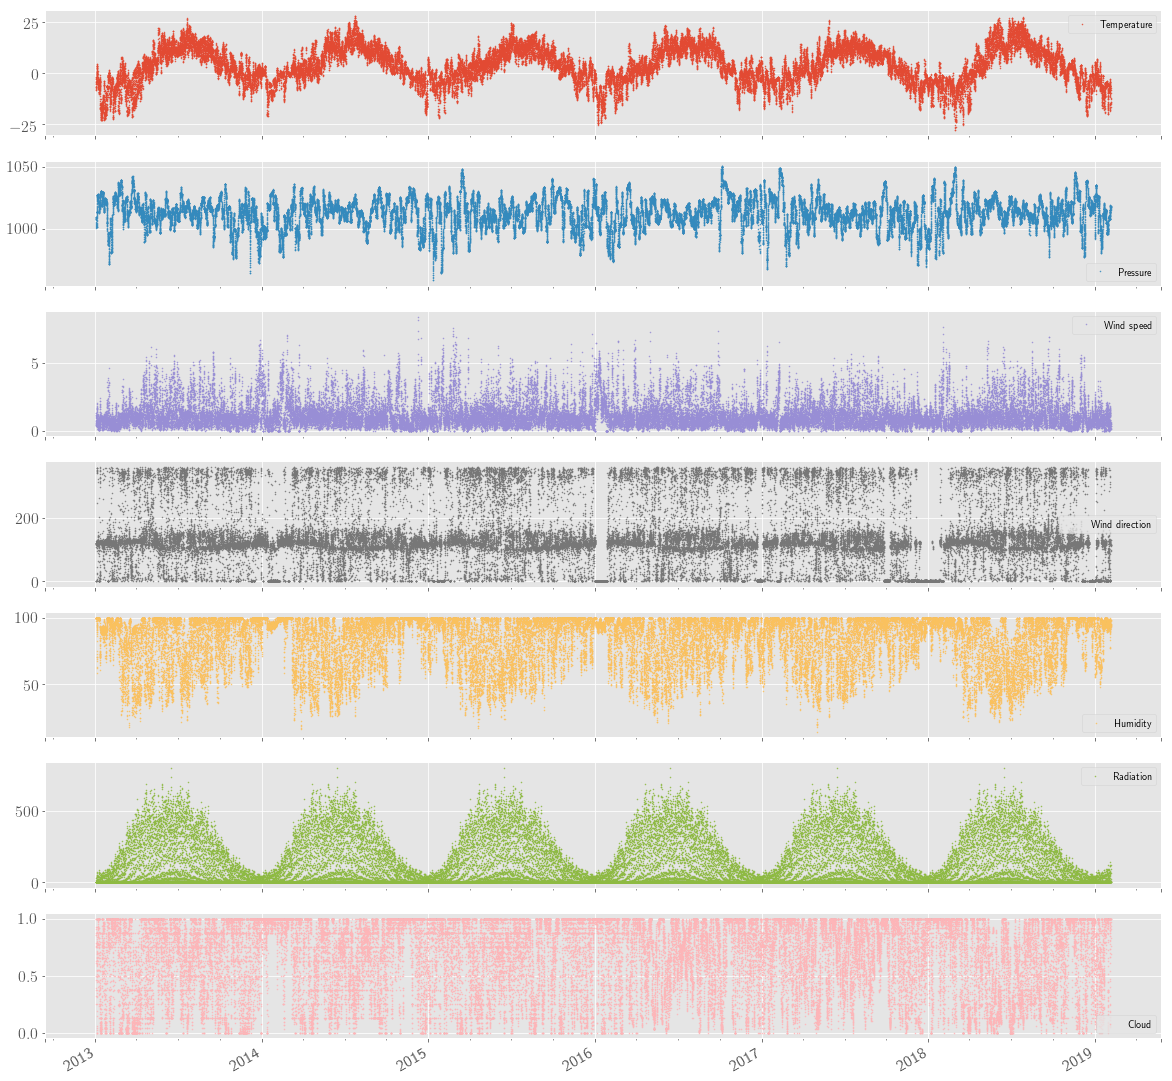

In [24]:
filled = pd.concat([filledTemp['Temperature'],
                    filledPressure['Pressure'],
                    filledWind['Wind speed'],
                    filledDir['Wind direction'],
                    filledHumidity['Humidity'],
                    filledRad['Radiation'],
                    filledCC['Cloud']
                    ],axis=1)

filled.plot(subplots=True, figsize=(20,3*len(filled.columns) ), marker='.', markersize=1, linestyle='None')
filled.columns=filled.columns.str.strip()
display(filled)

## Saving data to gotm format

In [25]:
result_dir = './results/'
create_dir(result_dir)
filled.index.name = '!Date'
filled.columns = filled.columns.str.replace(' ','_')
filled['u10'] = filled.Wind_speed * np.sin(np.deg2rad(filled.Wind_direction))
filled['v10'] = filled.Wind_speed * np.cos(np.deg2rad(filled.Wind_direction))

filled[['u10','v10','Pressure','Temperature','Humidity','Cloud']].to_csv(result_dir + 'langtjern-weather.dat',
                                                              sep = "\t",
                                                              float_format='%0.2f',
                                                              date_format = '%Y-%m-%d %H:%M:%S',
                                                              na_rep = 'NaN'
                                                              )
filled['Radiation'].to_csv(result_dir + 'langtjern-radiation.dat',
                    sep = "\t",float_format='%0.3f',
                    date_format = '%Y-%m-%d %H:%M:%S')

### Formatting inlet data

The data that were read are: Index(['CDOM', 'Temperature', 'Discharge'], dtype='object')


CDOM           6.694000e+01
Temperature    0.000000e+00
Discharge      2.343477e-08
dtype: float64

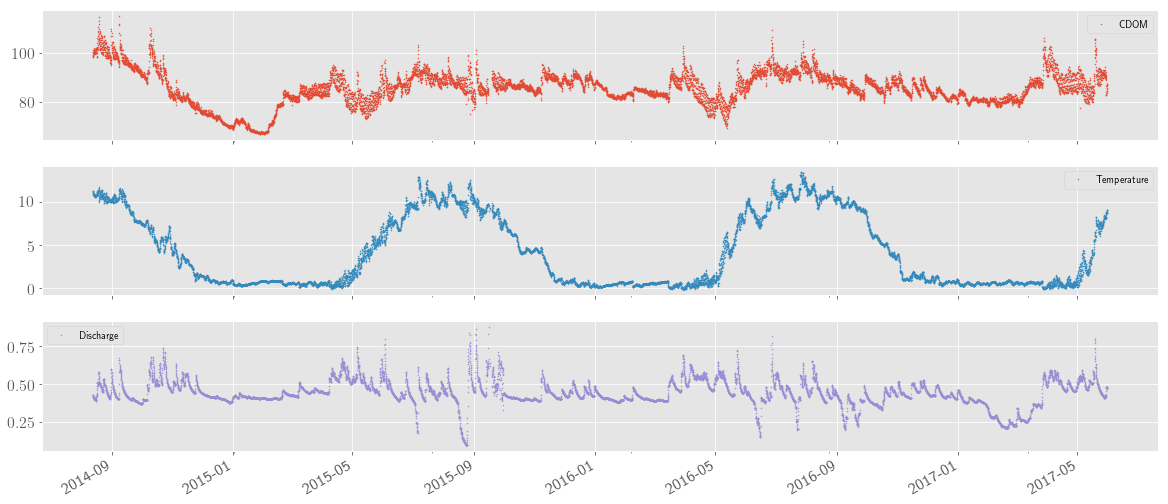

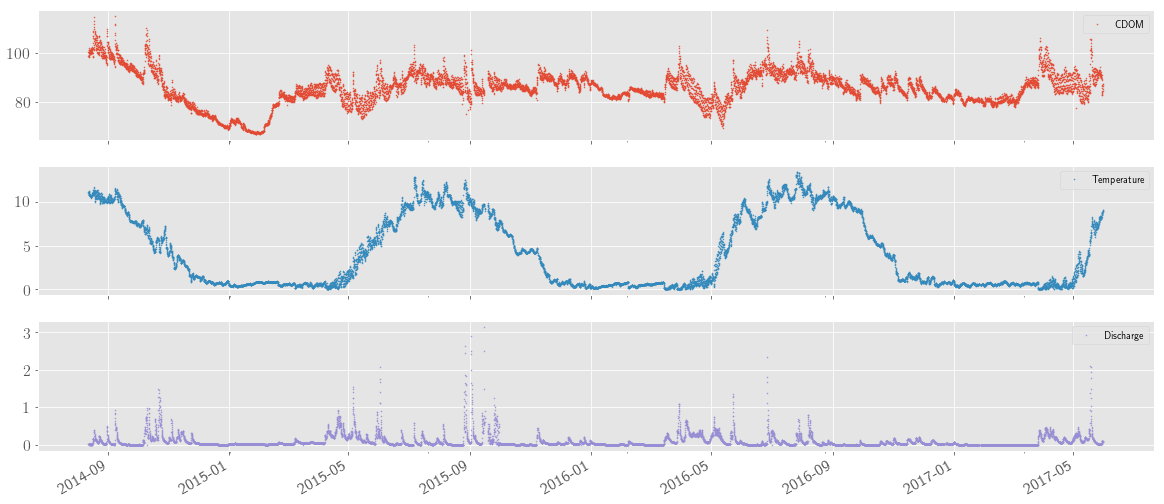

In [26]:
startDate = '2014-08-12 14:00:00'
endDate = '2017-05-31 00:00:00'

inlet = lw.getLangtjernData(username,password,root,
                           pd.datetime.strftime(start,'%Y/%m/%d'),
                           pd.datetime.strftime(finish,'%Y/%m/%d'),
                           63098,
                           'Water')
inlet.drop(['Depth1', 'Depth2','ProjectId', 'ProjectName', 'StationId', 'StationCode',
             'StationName','SampleDate_dato', 'SampleDate_tid'], inplace=True, axis=1) 

inlet = inlet.rename(columns=lambda x: re.sub('[_/]',' ',x))
inlet = inlet.rename(columns=lambda x: re.sub('µ','u',x))
inlet =  inlet.rename(columns={'Vannstand m':'Discharge',u'CDOM ug L' : 'CDOM', 'Temperatur C': 'Temperature'})
print("The data that were read are: {}".format(inlet.columns))

inlet[pd.Timestamp(startDate):pd.Timestamp(endDate)].plot(subplots=True,figsize=(20,3*len(inlet.columns)),linestyle='None',marker='.',markersize=1)

#Transforming stage into discharge
inletQ = lambda x : 2.391* np.power(x - 0.345, 2.5) if (x > 0.345) else 0.0001
inlet.Discharge = inlet.Discharge.apply(inletQ)
inlet.Discharge *= (4.8 + 0.23) / 0.8
inlet.Temperature[inlet.Temperature < 0.0] = 0.0

inlet[pd.Timestamp(startDate):pd.Timestamp(endDate)].plot(subplots=True,figsize=(20,3*len(inlet.columns)),linestyle='None',marker='.',markersize=1)

#Saving in gotm format
inlet = inlet[pd.Timestamp(startDate):pd.Timestamp(endDate)]
dischargeFile = 'inlet_discharge_m3_s.dat'
inlet[['Discharge','Temperature']].to_csv(result_dir + dischargeFile,
                        sep = "\t",
                        float_format='%0.4f',
                        date_format = '%Y-%m-%d %H:%M:%S',
                        na_rep = 'NaN'
                       )

temperatureFile = 'inlet_temperature_m3_s.dat'
inlet.Temperature.to_csv(result_dir + temperatureFile,
                        sep = "\t",
                        float_format='%0.4f',
                        date_format = '%Y-%m-%d %H:%M:%S',
                        na_rep = 'NaN'
                        )


display(inlet.min())
#We will only use the period until 2017-

In [27]:
display(inlet.min())

CDOM           6.694000e+01
Temperature    0.000000e+00
Discharge      2.343477e-08
dtype: float64

### Formatting lake data

In [4]:
lake = lw.getLangtjernData(username,password,root,
                           pd.datetime.strftime(start,'%Y/%m/%d'),
                           pd.datetime.strftime(finish,'%Y/%m/%d'),
                           50472,
                           'Water'
                          )
lake.columns = lake.columns.str.strip()
lake.index.name = 'Date'

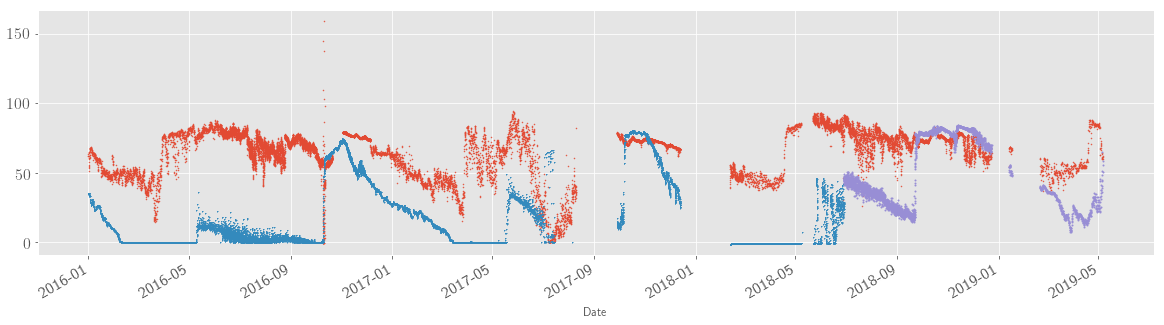

In [26]:
O2 = lake.loc[np.logical_not(np.isnan(lake['O2 (metning)_%'])),['Depth1','O2 (metning)_%']]
# O2 = O2.to_frame()
O2.columns = ['Depth','O2']
O2.to_csv('./DownloadedData/O2.csv')
O2.loc[O2.Depth==1.,'O2'].plot(figsize = (20,5),linestyle='None',marker='.',markersize=1)
O2.loc[O2.Depth==8.,'O2'].plot(linestyle='None',marker='+',markersize=1)
O2.loc[O2.Depth==6.,'O2'].plot(linestyle='None',marker='o',markersize=1)
plt.savefig('./DownloadedData/O2.png')

In [29]:
lake = lake.set_index([lake.index,lake['Depth1']])
lake['O2 (metning)_%'] = lake['O2 (metning)_%'] / 100.0 * ( (14.59 - 0.3955*lake['Temperatur_C'] +
                                                             0.0072*lake['Temperatur_C']*lake['Temperatur_C'] 
                                                             - 0.0000619*lake['Temperatur_C']*lake['Temperatur_C']*lake['Temperatur_C']) 
                                                           / 31.9988 
                                                          )

O2 = lake.loc[np.logical_not(np.isnan(lake['O2 (metning)_%'])),'O2 (metning)_%']
O2 = O2.to_frame()
O2.columns = ['O2']

#display(O2)
temperature = lake.loc[np.logical_not(np.isnan(lake['Temperatur_C'])),'Temperatur_C']
temperature = temperature.to_frame()
temperature.columns = ['temperature']
temperature[temperature.temperature < 0.0] = 0.
#display(max(temperature['temperature']))

In [30]:
def writeDepthVariable(filename,df,asObs = False) :
    filename = result_dir + filename + '.dat' 
    fid = open(filename,'w')
    if asObs :
        acpyFile = result_dir + filename + '.obs'
        fid_acpy = open(filename,'w')
    val_name = df.columns[0]    
    for date,sub_df in df.groupby(level='Date'):
        to_fabm = date.strftime('%Y-%m-%d %H:%M:%S') + ' ' + str(len(sub_df)) + ' 2\n'
        to_acpy = ''
        for i in zip(sub_df.index.get_level_values(level=1).values,sub_df[val_name].values):
            to_fabm += ' '.join(map("{:.4f}".format,i)) + '\n'
            to_acpy += date.strftime('%Y-%m-%d %H:%M:%S') + ' -' + ' '.join(map("{:.4f}".format,i)) + '\n'
        fid.write(to_fabm)
        if asObs :
            fid_acpy.write(to_acpy)
    fid.close()
    if asObs:
        fid_acpy.close()
        
writeDepthVariable('langtjern-lake-O2-concentration_mmol_m3',O2)        
writeDepthVariable('langtjern-temp-lake',temperature) 

### Formatting outlet data

The data that were read are: Index(['CDOM', 'Temperature', 'Discharge'], dtype='object')


CDOM           6.694000e+01
Temperature    0.000000e+00
Discharge      2.343477e-08
dtype: float64

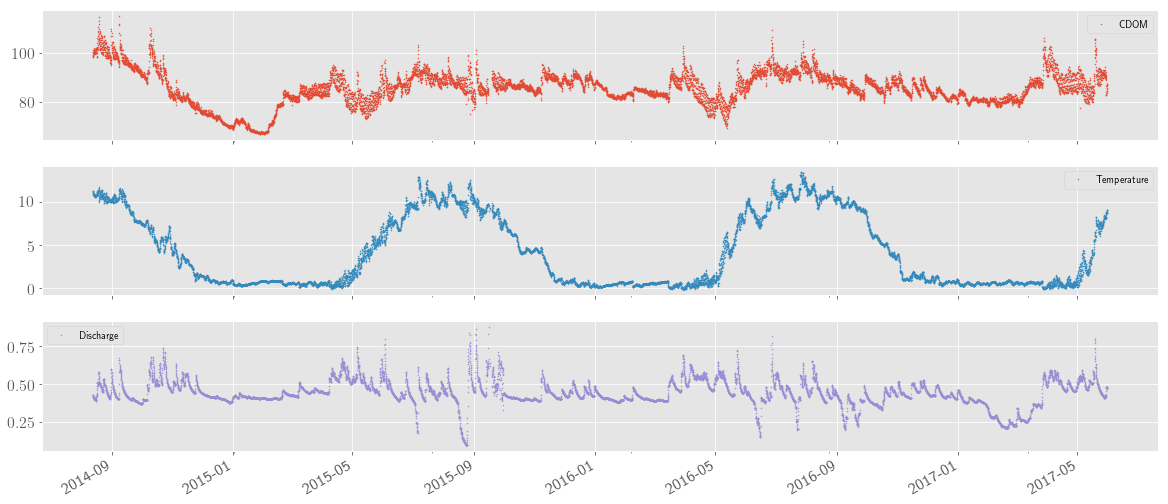

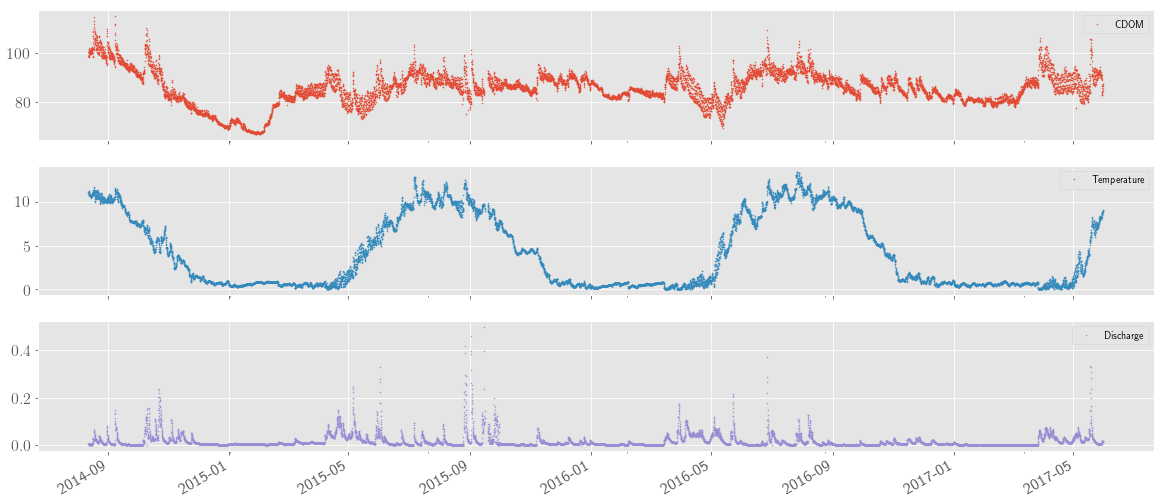

In [31]:
outlet = lw.getLangtjernData(username,password,root,
                           pd.datetime.strftime(start,'%Y/%m/%d'),
                           pd.datetime.strftime(finish,'%Y/%m/%d'),
                           63098,
                           'Water')
outlet.drop(['Depth1', 'Depth2','ProjectId', 'ProjectName', 'StationId', 'StationCode',
             'StationName','SampleDate_dato', 'SampleDate_tid'], inplace=True, axis=1) 

outlet = outlet.rename(columns=lambda x: re.sub('[_/]',' ',x))
outlet = outlet.rename(columns=lambda x: re.sub('µ','u',x))
outlet = outlet.rename(columns={'Vannstand m':'Discharge',u'CDOM ug L' : 'CDOM', 'Temperatur C': 'Temperature'})
print("The data that were read are: {}".format(inlet.columns))

outlet[pd.Timestamp(startDate):pd.Timestamp(endDate)].plot(subplots=True,figsize=(20,3*len(inlet.columns)),linestyle='None',marker='.',markersize=1)

#Transforming stage into discharge
outletQ = lambda x : 3.2136 * np.power(x - 0.315,2.453) if x > 0.37 else 3.794 * np.power(x - 0.315, 2.692)
outlet.Discharge = outlet.Discharge.apply(inletQ)
outlet.Temperature[outlet.Temperature < 0.0] = 0.0

outlet[pd.Timestamp(startDate):pd.Timestamp(endDate)].plot(subplots=True,figsize=(20,3*len(inlet.columns)),linestyle='None',marker='.',markersize=1)

#Saving in gotm format
outlet = outlet[pd.Timestamp(startDate):pd.Timestamp(endDate)]
dischargeFile = 'outlet_discharge_m3_s.dat'
outlet[['Discharge','Temperature']].to_csv(result_dir + dischargeFile,
                        sep = "\t",
                        float_format='%0.4f',
                        date_format = '%Y-%m-%d %H:%M:%S',
                        na_rep = 'NaN'
                       )

temperatureFile = 'outlet_temperature_m3_s.dat'
outlet.Temperature.to_csv(result_dir + temperatureFile,
                        sep = "\t",
                        float_format='%0.4f',
                        date_format = '%Y-%m-%d %H:%M:%S',
                        na_rep = 'NaN'
                        )


display(outlet.min())